In [1]:
import datetime

import colormaps
import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import xarray as xr
from jetutils.anyspell import get_persistent_jet_spells, mask_from_spells_pl, subset_around_onset, get_persistent_spell_times_from_som, get_spells, extend_spells, gb_index, make_daily
from jetutils.clustering import Experiment, RAW_REALSPACE, labels_to_centers
from jetutils.data import *
from jetutils.geospatial import *
from jetutils.definitions import *
from jetutils.jet_finding import *
from jetutils.plots import *
from matplotlib.cm import ScalarMappable
from matplotlib.colors import BoundaryNorm
from matplotlib.ticker import MaxNLocator
from pathlib import Path
from tqdm import tqdm
import polars.selectors as cs

%load_ext IPython.extensions.autoreload
%autoreload 2
%matplotlib inline

IPython could not be loaded!


Found config override file at  /storage/homefs/hb22g102/.jetutils.ini
Guessed N_WORKERS :  4
Guessed MEMORY_LIMIT :  153600


In [2]:
all_times = (
    pl.datetime_range(
        start=pl.datetime(1959, 1, 1),
        end=pl.datetime(2023, 1, 1),
        closed="left",
        interval="6h",
        eager=True,
        time_unit="ms",
    )
    .rename("time")
    .to_frame()
)
summer_filter = (
    all_times
    .filter(pl.col("time").dt.month().is_in([6, 7, 8, 9]))
    .filter(pl.col("time").dt.ordinal_day() > 166)
)
summer = summer_filter["time"]
summer_daily = summer.filter(summer.dt.hour() == 0)
big_summer = all_times.filter(pl.col("time").dt.month().is_in([6, 7, 8, 9]))
big_summer_daily = big_summer.filter(big_summer["time"].dt.hour() == 0)

dh = DataHandler("/storage/workspaces/giub_meteo_impacts/ci01/ERA5/plev/high_wind/6H/results/8")
exp = JetFindingExperiment(dh)
ds = exp.ds
all_jets_one_df = exp.find_jets(force=False, base_s_thresh=0.55, hole_size=6)
all_jets_one_df = exp.categorize_jets(None, ["s", "theta"], force=False, n_init=10, init_params="k-means++", mode="week").cast({"time": pl.Datetime("ms")})
props_uncat = exp.props_as_df(False).cast({"time": pl.Datetime("ms")})

props_as_df = average_jet_categories(props_uncat, polar_cutoff=0.5)

props_summer = summer_filter.join(props_as_df, on="time")
phat_filter = (pl.col("is_polar") < 0.5) | ((pl.col("is_polar") > 0.5) & (pl.col("int") > 1.3e8))

phat_jets = all_jets_one_df.filter((pl.col("is_polar").mean().over(["time", "jet ID"]) < 0.5) | ((pl.col("is_polar").mean().over(["time", "jet ID"]) > 0.5) & (pl.col("int").mode().first().over(["time", "jet ID"]) > 1.3e8)))
phat_jets_catd = phat_jets.with_columns(**{"jet ID": (pl.col("is_polar").mean().over(["time", "jet ID"]) > 0.5).cast(pl.UInt32())})
phat_props = props_uncat.filter(phat_filter)
phat_props_catd = average_jet_categories(phat_props, polar_cutoff=0.5)

phat_props_catd = phat_props_catd.join(phat_props_catd.rolling("time", period="2d", group_by="jet").agg(**{f"{col}_var": pl.col(col).var() for col in ["mean_lon", "mean_lat", "mean_s", "s_star"]}), on=["time", "jet"])

phat_props_catd_summer = summer_filter.join(phat_props_catd, on="time")

cross_catd_ofile = exp.path.joinpath("cross_catd.parquet")
if cross_catd_ofile.is_file():
    cross_catd = pl.read_parquet(cross_catd_ofile)
else:
    cross_catd = track_jets(phat_jets_catd)
    cross_catd.write_parquet(cross_catd_ofile)

pers = pers_from_cross_catd(cross_catd)
spells_list = spells_from_cross_catd_simple(cross_catd, season=summer, q_STJ=0.705, q_EDJ=0.836, minlen=datetime.timedelta(days=5), smooth=datetime.timedelta(hours=24), fill_holes=datetime.timedelta(hours=18))

daily_spells_list = {a: make_daily(b, "spell", ["len", "spell_of"]) for a, b in spells_list.items()}

# test

100%|██████████| 12/12 [00:25<00:00,  2.14s/it]


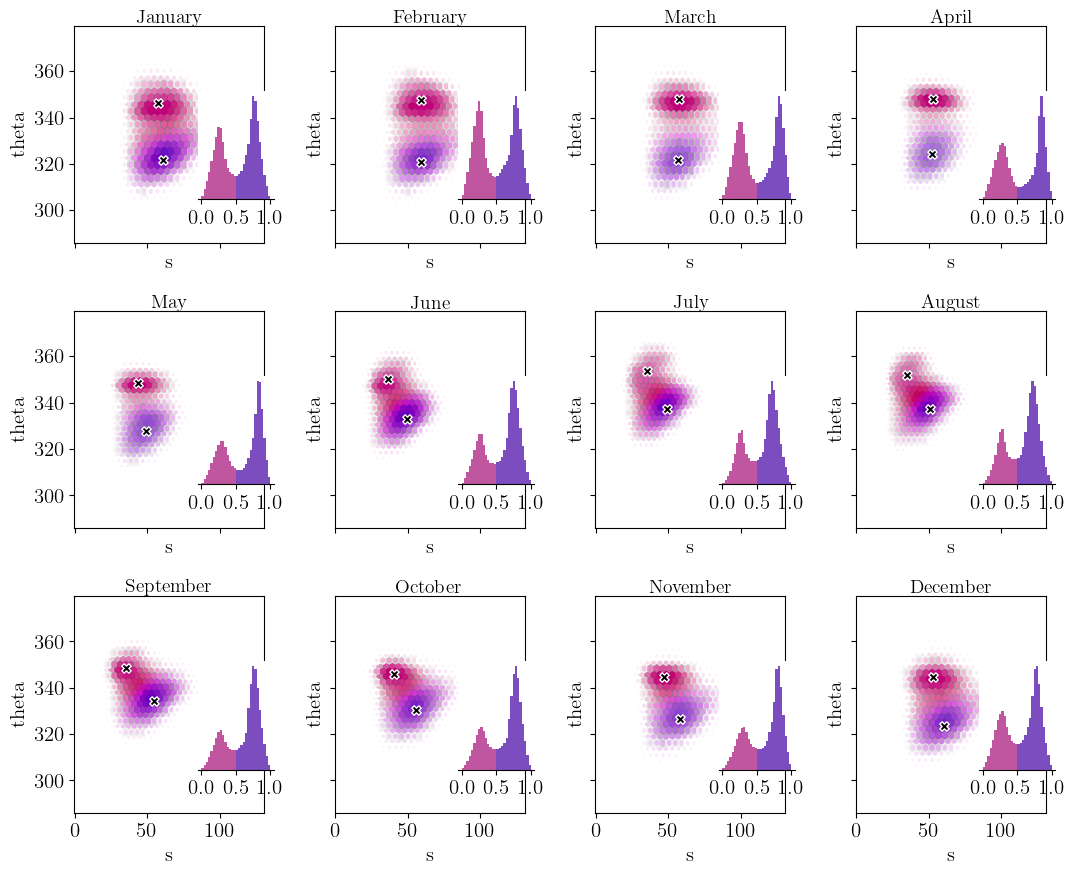

In [36]:
xys = []
all_jets = all_jets_one_df.filter(pl.col("int") > 1.1e8)
# .filter(pl.col("int") > 1.1e8)

xys = np.array(xys)
fig, axes = plt.subplots(3, 4, figsize=(11, 9), tight_layout=True, sharex="all", sharey="all")
axes = axes.ravel()
pair = ["s", "theta", "is_polar"]
cmap = LinearSegmentedColormap.from_list("pinkredpurple", [COLORS[2], COLORS_EXT[10], COLORS[1]])
bins = np.linspace(0, 1, 31)
for month in trange(1, 13):
    ax = axes[month - 1]
    X = extract_features(all_jets, pair, season=month)
    probas = X[pair[2]]
    center_stj = X.filter(pl.col("is_polar") < 0.3).mean()
    center_edj = X.filter(pl.col("is_polar") > 0.7).mean()
    X1D = X["is_polar"]
    
    im1 = ax.hexbin(X[pair[0]], X[pair[1]], cmap=colormaps.gray_r, gridsize=25)
    im2 = ax.hexbin(X[pair[0]], X[pair[1]], C=probas, cmap=colormaps.gray_r, gridsize=25)
    
    plt.draw()
        
    offsets1 = np.asarray(list(map(tuple, im1.get_offsets())), dtype="f, f")
    offsets2 = np.asarray(list(map(tuple, im2.get_offsets())), dtype="f, f")
    mask12 = np.isin(offsets1, offsets2)
    colors = cmap(im2.get_array())
    colors = rgb_to_hsv(colors[:, :3])
    min_s, max_s = 0., 1.0
    min_v, max_v = 0.75, 1.
    scaling = np.clip(im1.get_array()[mask12] / im1.get_array()[mask12].max() * 1.1, 0, 1)
    f = lambda x: np.sqrt(x)
    colors[:, 1] = min_s + scaling * (max_s - min_s)
    colors[:, 2] = max_v - scaling * (max_v - min_v)
    colors = hsv_to_rgb(colors)
    im2.set_array(None)
    im2.set_facecolor(colors)
    # im2.set_linewidths(0.2)
    im2.set_linewidths(4 * (1 - f(scaling)) ** 2)
    im2.set_edgecolor(colormaps.greys(scaling))
    im2 = ax.add_collection(im2)
        
    ax.set_xlabel(pair[0])
    ax.set_ylabel(pair[1])
    if pair[0] in ["lev", "theta"]:
        ax.invert_xaxis()
    elif pair[1] in ["lev", "theta"]:
        ax.invert_yaxis() 
        
    ax.set_title(MONTH_NAMES[month - 1])
    ax.scatter(*pl.concat([center_stj, center_edj])[pair[:2]].to_numpy().T, facecolor="black", edgecolor="white", marker="X", linewidths=1, s=45)
    iax = ax.inset_axes([0.65, 0.2, 0.4, 0.5])
    X1D = np.clip(X1D, 0, 1)
    iax.hist(X1D, bins=bins, alpha=0.5, color="black")
    iax.hist(X1D[probas > 0.5], bins=bins, alpha=0.5, color=COLORS[1])
    iax.hist(X1D[probas < 0.5], bins=bins, alpha=0.5, color=COLORS[2])
    iax.set_xticks([0, 0.5, 1])
    iax.set_yticks([])
    iax.spines[["left", "right", "top"]].set_visible(False)
    plt.draw()
# fig.savefig(f"{FIGURES}/jet_detection_demo/gmix_demo")

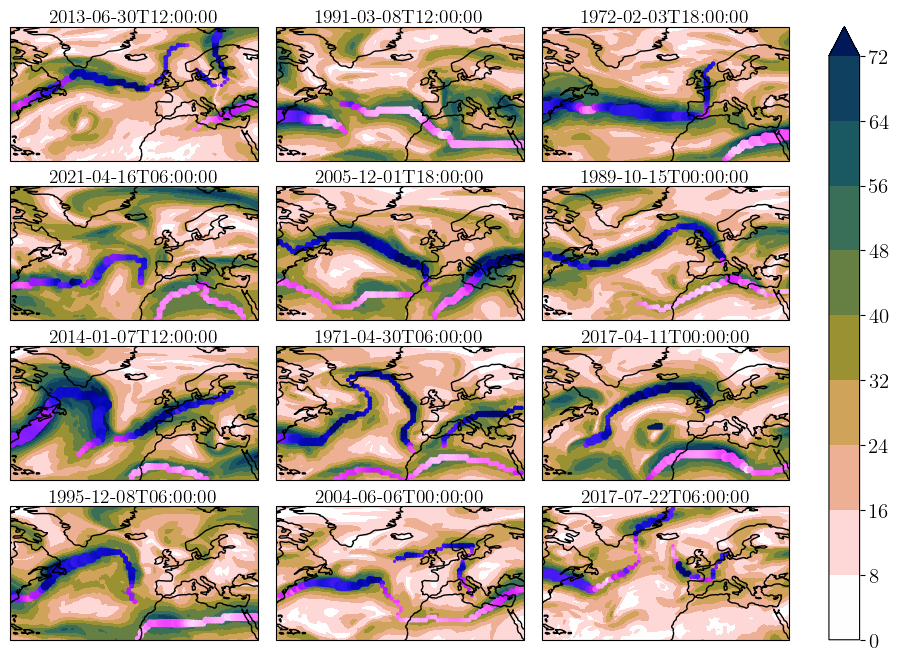

In [60]:
all_t = ds["time"]
ncol, nrow = 3, 4
n = ncol * nrow
ts = np.random.choice(all_t, size=n)
to_plot = ds["s"].sel(time=ts)
titles = np.datetime_as_string(ts, unit="s")
clu = Clusterplot(nrow, ncol, get_region(ds))
clu.add_contourf(to_plot, titles=titles, cmap=colormaps.batloww_r, levels=9)

for i, t in enumerate(ts):
    jets = all_jets_one_df.filter(pl.col("time") == t)
    for j, jet in jets.group_by("jet ID"):
        lo, la, s, is_p = jet["lon", "lat", "s", "is_polar"]
        clu.axes[i].scatter(lo - clu.central_longitude, la, s=(s - 10) ** 2 / 100, c=is_p, vmin=0, vmax=1, cmap=colormaps.cet_l_bmw_r)

# Persistence quantiles vs props

In [4]:
import CDSK

da_ = coarsen_da(exp.ds["s"].sel(time=np.isin(exp.ds.time.dt.month, [6, 7, 8, 9])), 4, np.amax)
# da_anom = compute_anomalies_ds(da_, "dayofyear", standardized=True).sel(time=np.isin(da_.time.dt.month, [6, 7, 8, 9]))
X = da_.values.reshape(da_.shape[0], -1)

In [5]:
opath_dim = exp.path.joinpath("dim.parquet")
opath_theta = exp.path.joinpath("theta.parquet")
if opath_dim.is_file() and opath_theta.is_file():
    dim_pd = pl.read_parquet(opath_dim)
    theta_pd = pl.read_parquet(opath_theta)
else:
    a, b, c = CDSK.dynamical_local_indexes(X, n_jobs=N_WORKERS)
    dim = a[:, 0, 0]
    theta = b[:, 0, 0]
    dim_pd = pl.DataFrame({"time": da_.time.values, "dim": dim})
    theta_pd = pl.DataFrame({"time": da_.time.values, "theta": theta})
    dim_pd.write_parquet(opath_dim)
    theta_pd.write_parquet(opath_theta)

In [6]:
speed_realspace = ((da_[1:].data - da_[:-1].data) ** 2).sum(axis=(1, 2))
speed_pd = pl.DataFrame({"time": da_.time.values[:-1], "speed": speed_realspace})
pers = pl.read_parquet(exp.path.joinpath("pers_catd_all_year.parquet"))

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), constrained_layout=True)
axes = axes.ravel()
for i, to_plot in enumerate([dim_pd, theta_pd, speed_pd]):
    ax = axes[i]
    name = to_plot.columns[-1]
    for jet in ["STJ_catd", "EDJ_catd"]:
        spells = spells_list[jet]
        huh = mask_from_spells_pl(spells_list[jet], to_plot, time_before=datetime.timedelta(days=4))
        x, y = huh.group_by("relative_index").mean().sort("relative_index")[["relative_index", name]].to_numpy().T
        x = x / 4
        ax.plot([x[0], x[-1]], [to_plot[name].mean()] * 2, color="black")
        ax.plot(x, y, color=COLORS[2 - int(jet=="EDJ_catd")], lw=3, label=jet[:3])
    ax.set_xlabel("Relative time around offset [day]")
axes[0].set_title("Local dimension $d$")
axes[1].set_title(r"Extremal factor $\theta$")
axes[0].legend(ncol=2)
fig.savefig(f"{FIGURES}/jet_persistence/dst.png")

In [8]:
from itertools import pairwise
props_as_df_anoms = compute_anomalies_pl(phat_props_catd.filter(pl.col("time").dt.month().is_in([6, 7, 8, 9])), standardize=True)
from jetutils.jet_finding import pers_from_cross_catd
pers = pl.read_parquet(exp.path.joinpath("pers_catd_all_year.parquet")).filter(pl.col("time").dt.month().is_in([6, 7, 8, 9]))
n_q = 31
data_vars = [
    "mean_lat",
    "mean_theta",
    "mean_s",
    "tilt",
    "waviness1",
    "width",
]
prettier_index = {
    "theta": "Inv. DST extremal index",
    "dim": "DST local dimension",
    "speed": "Inv. T2T distance",
    "pers": "Jet persistence",
}
cm = colormaps.bold
colors_props = cm(np.linspace(0, 1 - 1 / cm.N, cm.N) + 1 / 2 / cm.N)
vs_quantiles = {
    data_var: np.zeros(n_q - 1) for data_var in data_vars
}
qs = np.linspace(0, 1, n_q)
to_plots = {"theta": theta_pd, "dim": dim_pd, "speed": speed_pd, "pers": pers}
fig, axes = plt.subplots(len(to_plots), 2, figsize=(10, 10), sharex="all", sharey="col", gridspec_kw={"hspace": 0.23})
for i, (name, to_plot) in enumerate(to_plots.items()):
    name = to_plot.columns[-1]
    for j, jet in enumerate(["STJ", "EDJ"]):
        ax = axes[i, j]
        if name=="pers":
            to_plot_ = to_plot.filter(pl.col("spell_of") == jet)
        elif name in ["theta", "speed"]:
            to_plot_ = to_plot.with_columns(1 / pl.col(name))
        else:
            to_plot_ = to_plot
        to_plot_ = to_plot.cast({"time": pl.Datetime("ms")})
        for k, (q1, q2) in enumerate(pairwise(qs)):
            props = (
                to_plot_
                .filter(
                    (pl.col(name) < pl.col(name).quantile(q2)) & 
                    (pl.col(name) >= pl.col(name).quantile(q1))
                )[["time"]]
                .join(
                    props_as_df_anoms
                    .filter(pl.col("jet") == jet), 
                    on="time"
                )
                .mean()
            )
            for data_var in data_vars:
                vs_quantiles[data_var][k] = props[data_var].item()
            ax.axhline(0, color="black")
        for k, (data_var, huh) in enumerate(vs_quantiles.items()):
            ax.plot((qs[:-1] + qs[1:]) / 2, huh, label=PRETTIER_VARNAME[data_var], color=colors_props[k], lw=2)
        ax.set_title(f"{prettier_index[name]}, props. of the {jet[:3]}", pad=4)
fig.supxlabel("Quantile of the persistence prop.", y=0.05)
fig.supylabel("Standardized anomaly of the jet property", x=0.06)
axes[-1, 0].legend(bbox_to_anchor=[2, -.35], ncol=3, title="Jet properties")
axes[-1, -1].set_xlim([0, 1])
fig.savefig(f"{FIGURES}/jet_persistence/pers_props_quantiles.png")

In [9]:
pers.filter((pl.col("pers") < pl.col("pers").quantile(q2)) & (pl.col("pers") >= pl.col("pers").quantile(q1)))[["time"]].join(props_as_df_anoms.filter(pl.col("jet") == "EDJ"), on="time").mean()

# grams weather regimes

In [4]:
dh = DataHandler.from_specs("ERA5", "plev", "z", "6H", "all", [6, 7, 8, 9], -80, 40, 15, 80, 500, "dayofyear", {"dayofyear": ("win", 15)}, None)

exp_z = Experiment(dh)
centers_z, labels_z = exp_z.do_kmeans(4, 30, weigh_grams=False)

coslat = np.cos(np.deg2rad(centers_z.lat))
Pwr = (dh.da * centers_z * coslat).sum(["lon", "lat"]) / coslat.sum() / centers_z.lon.shape[0]
Iwr = (Pwr - Pwr.mean("time")) / Pwr.std("time", ddof=0)
Iwr = compute(Iwr)
Iwr = xarray_to_polars(Iwr.rename("Iwr")).drop("ratio", "label")

# Iwr = Iwr.with_columns(year=pl.col("time").dt.year())
sigma_wr = Iwr["Iwr"].std()
winner = Iwr.group_by("time", maintain_order=True).agg(pl.col("Iwr").arg_max().alias("winner"), pl.col("Iwr").max(), pl.col("time").dt.year().alias("year").first())
winner = winner.with_columns(winner=pl.when(pl.col("Iwr") > sigma_wr).then(1 + pl.col("winner")).otherwise(pl.lit(0)))
start_of_year = winner.group_by("year", maintain_order=True).len().with_columns(start_of_year=pl.col("len").cum_sum() - pl.col("len").get(0)).drop("len")
to_zero = (
    winner
    .group_by("year", maintain_order=True)
    .agg(pl.col("winner").rle().alias("rle"))
    .explode("rle")
    .unnest("rle")
    .group_by("year", maintain_order=True)
    .agg(
        len=pl.col("len"),
        start=pl.lit(0).append(
            pl.col("len").cum_sum().slice(0, pl.col("len").len() - 1)
        ),
        value=pl.col("value"),
    )
    .explode(["len", "start", "value"])
    .join(start_of_year, on="year")
    .with_columns(start=pl.col("start") + pl.col("start_of_year"))
    .drop("start_of_year")
    .filter(pl.col("len") < 20, pl.col("value") > 0)
    .drop("value")
    .with_columns(
        index=pl.int_ranges(pl.col("start"), pl.col("start") + pl.col("len"))
    )
    .drop("len", "start")
    .explode("index")
)[:, "index"]
winner[to_zero, "winner"] = 0

mask_updated = labels_to_mask(winner[:, "winner"].to_numpy())

In [5]:
["Greenland Blocking", "Zonal regime", "EuBL/AR", "ScBl"]

In [8]:
clu = Clusterplot(2, 2, get_region(exp_z.da))
clu.add_contourf([dh.da[winner["winner"] == i].mean("time") / 9.8 for i in range(1, 5)], cmap=colormaps.BlWhRe, levels=[-100, - 60, -20, 20, 60, 100], titles=[str(i) for i in range(1, 5)])
a = 1

In [9]:
winner.write_parquet(dh.path.joinpath("grams_wr.parquet"))

# Real space composites

In [3]:
args1 = ["all", [6, 7, 8, 9], *get_region(ds)]
args2 = ["dayofyear", {"dayofyear": ("win", 15)}]
da_T_anom = DataHandler.from_specs(
    "ERA5",
    "surf",
    "t2m",
    "dailymean",
    *args1,
    "all",
    *args2,
).da
da_T_anom = compute(da_T_anom, progress_flag=True)
# da_tp_anom = DataHandler.from_specs(
#     "ERA5",
#     "surf",
#     "tp",
#     "dailysum",
#     *args1,
#     "all",
#     *args2,
# ).da
# da_tp_anom = compute(da_tp_anom, progress_flag=True)
da_theta2pvu = DataHandler.from_specs(
    "ERA5",
    "surf",
    ("alot2pvu", "theta"),
    "6H",
    *args1
).da
da_theta2pvu = compute(da_theta2pvu, progress_flag=True)
da_tp = DataHandler.from_specs(
    "ERA5",
    "surf",
    "tp",
    "6H",
    *args1
).da
da_tp = compute(da_tp, progress_flag=True)
# da_theta2pvu_anom = DataHandler.from_specs(
#     "ERA5",
#     "surf",
#     "theta2PVU",
#     "6H",
#     *args1,
#     "all",
#     *args2,
# ).da
# da_theta2pvu_anom = compute(da_theta2pvu_anom, progress_flag=True)
da_z500_anom = DataHandler.from_specs(
    "ERA5",
    "plev",
    "z",
    "6H",
    *args1, 
    500,
    *args2,
).da
da_z500_anom = compute(da_z500_anom, progress_flag=False).rename("z500") / 9.8
# da_pv330 = DataHandler.from_specs(
#     "ERA5",
#     "thetalev",
#     "PV330",
#     "6H",
#     *args1, 
#     330,
# ).da
# da_pv330 = compute(da_pv330, progress_flag=True).rename("pv330") * 1e6

# da_pv350 = DataHandler.from_specs(
#     "ERA5",
#     "thetalev",
#     ("PV350", "pv"),
#     "6H",
#     *args1, 
#     350,
# ).da
# da_pv350 = compute(da_pv350, progress_flag=True).rename("pv350") * 1e6

# da_s = compute(ds["s"].sel(time=ds.time.dt.month.isin([6, 7, 8, 9])), progress_flag=True)

args = ["all", [6, 7, 8, 9], *get_region(ds), "all"]
varnames_rwb = ["APVO", "CPVO"]
das_rwb = {}
for var in varnames_rwb:
    das_rwb[var] = compute(open_da("ERA5", "thetalev", var, "6H", *args), progress_flag=True)

[########################################] | 100% Completed | 1.51 ss
[########################################] | 100% Completed | 14.09 s
[########################################] | 100% Completed | 3.22 ss
[########################################] | 100% Completed | 66.21 s
[########################################] | 100% Completed | 68.53 s


In [4]:
long_names = {
    "t2m": "2m temperature [K]",
    "t_up": "Upper level temperature [K]",
    "tp": "Daily accum. precip. [mm]",
    "apvs": r"Anticyclonic PV streamer freq [$\%$]",
    "cpvs": r"Cyclonic PV streamer freq [$\%$]",
    "theta": "Upper-level Potential temperature [K]",
    "s": r"Wind speed [$\mathrm{m.s}^{-1}$]",
    "theta": "Pot temp at 2 PVU [K]",
    "z200": "Z200 anomaly [m]",
    "z500": "Z500 anomaly [m]",
    "pv330": "PV at 330K [PVU]",
    "pv350": "PV at 350K [PVU]",
} | {key: f"{key} []" for key in das_rwb}

## clusterize

In [ ]:
clusters_da = np.abs(xr.open_dataarray(Path(DATADIR, "ERA5/heatwaves_duncan/cluster_df.nc")).load())
clusters_da = clusters_da.interp(lat=np.arange(32, 72, 0.5), method="nearest")
clu = Clusterplot(1, 1, (-10, 40, 35, 72), row_height=5)
cmap = colormaps.pastel
ax = clu.axes[0]
unique_clusters = np.arange(1, 7)
norm = BoundaryNorm(np.arange(cmap.N) + 0.5, cmap.N)
clusters_da.assign_coords(lon=clusters_da.lon - clu.central_longitude).plot(
    ax=ax,
    cmap=cmap,
    norm=norm,
    add_colorbar=False,
    add_labels=False
)
for j in range(6):
    lo = clusters_da.lon.where(clusters_da==(j + 1)).mean().item() - j - 2 * (j == 0) + 2 * (j == 2) + 1.5 * (j == 1) - (j == 4)  - clu.central_longitude
    la = clusters_da.lat.where(clusters_da==(j + 1)).mean().item() - (j == 5) * 2
    color = "black"
    ax.text(lo, la, DUNCANS_REGIONS_NAMES[j], ha="center", va="center", fontweight="bold", color=color)

plt.savefig(f"{FIGURES}/jet_persistence/regions.png")

In [ ]:
from jetutils.anyspell import regionalize
region_T_ts = regionalize(da_T_anom, clusters_da, ["time"])
region_tp_ts = regionalize(da_tp_anom, clusters_da, ["time"])

In [ ]:
region_T_ts.write_parquet("/storage/workspaces/giub_meteo_impacts/ci01/ERA5/surf/t2m/dailymean/dayofyear_doywin15/results/1/regionalized.parquet")

In [ ]:
region_tp_ts.write_parquet("/storage/workspaces/giub_meteo_impacts/ci01/ERA5/surf/tp/dailysum/dayofyear_doywin15/results/1/regionalized.parquet")

## composites, all spells

100%|██████████| 2/2 [00:00<00:00, 628.17it/s]


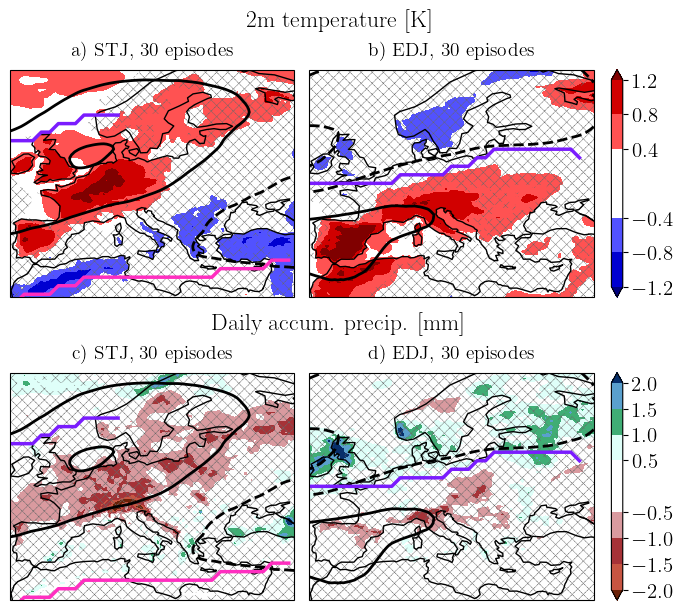

In [20]:
from string import ascii_lowercase
from cartopy.mpl.geoaxes import GeoAxes
plt.rc("axes", titlesize=14)
da_contour = da_z500_anom.sel(time=(da_z500_anom.time.dt.hour == 0) & (da_z500_anom.time.dt.year>=1959), lon=slice(-10, 40), lat=slice(30, 70))
da_1 = da_T_anom.copy().sel(lon=slice(-10, 40), lat=slice(30, 70))
cbar_kwargs = {"shrink": 1.0, "fraction": 0.11, "pad": 0.03}
plot_kwargs_1 = {
    "cmap": colormaps.BlWhRe, 
    "levels": [-1.2, -0.8, -.4, .4, 0.8, 1.2], 
    "transparify": 1, 
    "cbar_kwargs": cbar_kwargs
}
da_2 = da_tp_anom.copy().sel(lon=slice(-10, 40), lat=slice(30, 70)) * 1000
plot_kwargs_2 = {
    "cmap": colormaps.precip4_diff_19lev,
    "levels": np.linspace(-2, 2, 9).tolist(),
    "transparify": 0, 
    "cbar_kwargs": cbar_kwargs,
}
stippling_kwargs = {
    "FDR": True,
    "invert": True,
    "linewidth": 0.3,
    "color": "dimgrey",
    "hatch": "xxxx",
}
nrow, ncol = 1, 2
days_around = 5
n = nrow * ncol
cmap = colormaps.pastel
norm = BoundaryNorm(np.arange(cmap.N) + 0.5, cmap.N)
bigfig = plt.figure(figsize=(6.8, 6), constrained_layout=True)
subfigs = bigfig.subfigures(2, 1)
for da, plot_kwargs, fig in zip([da_1, da_2], [plot_kwargs_1, plot_kwargs_2], subfigs):
    clu = Clusterplot(nrow, ncol, get_region(da), fig=fig)
    mask = np.zeros((len(da.time), len(spells_list)), dtype=bool)
    titles = []
    for j, jet in enumerate(spells_list):
        spells_from_jet_daily = subset_around_onset(daily_spells_list[jet], around_onset=datetime.timedelta(days=days_around))
        letter = ascii_lowercase[j % len(ascii_lowercase) + len(clu.axes) * int(da.name == "tp")]
        mask[:, j] = np.isin(
            da.time.values,
            spells_from_jet_daily["time"]
        )
        n_spells = spells_from_jet_daily["spell"].n_unique()
        titles.append(f"{letter}) {jet[:3]}, {n_spells} episodes")
    _ = clu.add_any_contour_from_mask(da, mask, type="contourf", stippling=True, titles=titles, stippling_kwargs=stippling_kwargs, **plot_kwargs)
    _ = clu.add_any_contour_from_mask(da_contour, mask, type="contour", levels=[-60, -20, 20, 60], linewidths=2., clabels=False)
    fig.suptitle(long_names[da.name])
    
masked_da = []
time_name = "time"
reduction_function = np.nanmean
for mas in mask.T:
    masked_da.append(ds.sel(time=(ds.time.dt.month.isin([6, 7, 8, 9])) & (ds.time.dt.hour == 0)).isel({time_name: mas}).reduce(reduction_function, dim=time_name))
masked_da = xr.concat(masked_da, dim="relative_index")
jets_on_mean = find_all_jets(masked_da)
for fig in subfigs:
    for ax, (_, jets) in zip(fig.axes, jets_on_mean.group_by("relative_index")):
        if not isinstance(ax, GeoAxes):
            continue
        for _, jet_ in jets.group_by("jet ID"):
            lo, la = jet_[["lon", "lat"]]
            if la.mean() > 40: 
                color = COLORS[1]
            else:
                color = COLORS[2]
            ax.plot(lo - clu.central_longitude, la, lw=2.5, color=color)
bigfig.savefig(f"{FIGURES}/jet_persistence/realspace_stuff/t2m_and_tp_realspace_both_30spells.png")

In [21]:
f"{FIGURES}/jet_persistence/realspace_stuff/t2m_and_tp_realspace_both_30spells.png"

'/storage/homefs/hb22g102/persistent-extremes-era5/Figures/jet_persistence/realspace_stuff/t2m_and_tp_realspace_both_30spells.png'

## Individual spells

#### the case study plot

In [11]:
spells_list["STJ"].filter(pl.col("time").dt.year() == 2003)

spell,len,time,relative_time,start,value,index,pers,relative_index,spell_of
u32,u32,datetime[ms],duration[ms],i64,bool,u32,f64,i32,str
16,24,2003-08-07 06:00:00,0ms,18918,true,18918,0.014134,0,"""STJ"""
16,24,2003-08-07 12:00:00,6h,18918,true,18919,0.057887,1,"""STJ"""
16,24,2003-08-07 18:00:00,12h,18918,true,18920,0.043314,2,"""STJ"""
16,24,2003-08-08 00:00:00,18h,18918,true,18921,0.056227,3,"""STJ"""
16,24,2003-08-08 06:00:00,1d,18918,true,18922,0.057165,4,"""STJ"""
…,…,…,…,…,…,…,…,…,…
16,24,2003-08-12 00:00:00,4d 18h,18918,true,18937,0.04104,19,"""STJ"""
16,24,2003-08-12 06:00:00,5d,18918,true,18938,0.055413,20,"""STJ"""
16,24,2003-08-12 12:00:00,5d 6h,18918,true,18939,0.060049,21,"""STJ"""


shape: (24, 5)
┌───────────┬────────────┬───────────┬─────────────┬─────────────┐
│ mean_lat  ┆ mean_theta ┆ mean_s    ┆ wavinessR16 ┆ width       │
│ ---       ┆ ---        ┆ ---       ┆ ---         ┆ ---         │
│ f32       ┆ f64        ┆ f32       ┆ f32         ┆ f32         │
╞═══════════╪════════════╪═══════════╪═════════════╪═════════════╡
│ -3.356705 ┆ -1.397206  ┆ -9.297302 ┆ -1.018194   ┆ -42492.125  │
│ -2.737778 ┆ -0.40924   ┆ -7.605207 ┆ -1.217328   ┆ -14068.6875 │
│ -3.03215  ┆ 1.038622   ┆ -8.134308 ┆ -1.217328   ┆ 112641.75   │
│ -3.995949 ┆ -0.821862  ┆ -8.56283  ┆ -1.21183    ┆ 41543.3125  │
│ -4.092266 ┆ -0.830874  ┆ -8.294384 ┆ -1.24308    ┆ 29806.0625  │
│ …         ┆ …          ┆ …         ┆ …           ┆ …           │
│ -4.599201 ┆ 5.033209   ┆ 0.753799  ┆ -0.56441    ┆ -93025.1875 │
│ -4.487122 ┆ 3.511854   ┆ -3.289497 ┆ -0.578299   ┆ 65266.5625  │
│ -4.714966 ┆ 2.431325   ┆ -2.761425 ┆ -0.625124   ┆ 66218.75    │
│ -4.457153 ┆ 3.335579   ┆ -2.254917 ┆ -0.55705

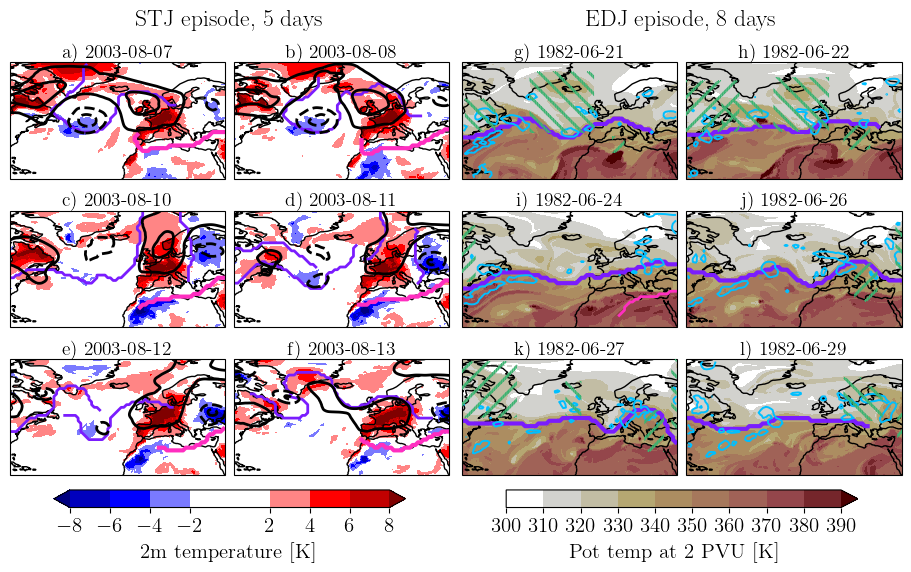

In [19]:
from jetutils.data import compute_anomalies_pl
props_anom = compute_anomalies_pl(phat_props_catd, ["jet"])

n_stj = 16
n_edj = 7
figure = plt.figure(layout='constrained', figsize=(9, 5.6))
subfigs = figure.subfigures(1, 2, wspace=0.01)
fig1, fig2 = subfigs
nrow, ncol = 3, 2
n = nrow * ncol
plt.rc("axes", titlesize=14)
plt.rc("axes", titlepad=2)

rwb_color = "mediumseagreen"
rwb_lw = 2

cbar_kwargs = {"location": "bottom", "shrink": 0.8, "fraction": 0.1, "pad": 0.03}
plot_kwargs_all = {
    "STJ": {"cmap": colormaps.BlWhRe, "levels": MaxNLocator(9).tick_values(-8, 8).tolist(), "cbar_kwargs": cbar_kwargs},
    "EDJ": {"cmap": colormaps.bilbao_r, "levels": MaxNLocator(11).tick_values(300, 390).tolist(), "cbar_kwargs": cbar_kwargs},
}

for fig, key, da, which_spell in zip(subfigs, ["STJ", "EDJ"], [da_T_anom, da_theta2pvu], [n_stj, n_edj]):
    is_edj = key == "EDJ"
    plot_kwargs = plot_kwargs_all[key]
    clu = Clusterplot(nrow, ncol, get_region(da), row_height=3.5, fig=fig)
    spell = spells_list[key].filter(pl.col("spell") == which_spell)
    spell = extend_spells(spell, time_before=datetime.timedelta(days=0))
    len_spell = spell["time"][-1] - spell["time"][0]
    
    times = pl.linear_space(spell["time"][0], spell["time"][-1], n, eager=True).dt.round("1d").cast(pl.Datetime("ms"))
    titles = times.dt.to_string("%Y-%m-%d").to_list()
    titles = [f"{ascii_lowercase[n * is_edj + i]}) {title}" for i, title in enumerate(titles)]
    to_plot = da.sel(time=times)
    clu.add_contourf(to_plot, titles=titles, cbar_label=long_names[da.name], **plot_kwargs)
    fig.suptitle(f"{key} episode, " + str(len_spell)[:6])
    
    for i, t in enumerate(times):
        if i == 0 and t < spell["time"][0]:
            t_ = spell["time"][0]
        else:
            t_ = t
        phat_jets_ = phat_jets.filter(pl.col("time") == t_)
        for _, jet in phat_jets_.group_by("jet ID"):
            lo, la, is_p = jet[["lon", "lat", "is_polar"]]
            this_jet_is_p = len(is_p) > 0 and is_p.mean() > 0.45
            color = COLORS[1] if this_jet_is_p else COLORS[2]
            lw = 2 + 1 * (is_edj == this_jet_is_p)
            clu.axes[i].plot(lo - clu.central_longitude, la, color=color, lw=lw)
    if key == "STJ":
        to_plot = da_z500_anom.sel(time=times)
        clu.add_contour(to_plot, levels=[-200, -100, 100, 200], colors="black", linewidths=2.)
    if key == "EDJ":
        to_plot = das_rwb["APVO"].sel(time=times, lev=slice(320, 340)).any("lev")
        for ax, ouais in zip(clu.axes, to_plot):
            cs = ax.pcolor(
                to_plot.lon.values - clu.central_longitude,
                to_plot.lat.values,
                ouais.where(ouais),
                hatch="//", 
                facecolor="none", 
                edgecolor=rwb_color, 
                hatch_linewidth=rwb_lw, 
                linewidth=0,
                zorder=100
            )
        to_plot = das_rwb["CPVO"].sel(time=times, lev=slice(320, 340)).any("lev")
        for ax, ouais in zip(clu.axes, to_plot):
            cs = ax.pcolor(
                to_plot.lon.values - clu.central_longitude,
                to_plot.lat.values,
                ouais.where(ouais),
                hatch=r"\\",
                facecolor="none", 
                edgecolor=rwb_color, 
                hatch_linewidth=rwb_lw, 
                linewidth=0,
                zorder=100
            )
        to_plot = coarsen_da(da_tp.sel(time=times), 3)
        clu.add_contour(to_plot * 1000, levels=[15], colors=["deepskyblue"], linewidths=1.4)
    print(props_anom.filter(pl.col("time").is_in(spell["time"].implode()), pl.col("jet") == key)[["mean_lat", "mean_theta", "mean_s", "wavinessR16", "width"]])
    
figure.savefig(f"{FIGURES}/jet_persistence/realspace_stuff/case_study_both.png")

In [20]:
f"{FIGURES}/jet_persistence/realspace_stuff/case_study_both.png"

'/storage/homefs/hb22g102/persistent-extremes-era5/Figures/jet_persistence/realspace_stuff/case_study_both.png'

#### the other ones

In [33]:
plt.rc("axes", titlesize=13)
da = da_theta2pvu.copy()
cmap = colormaps.bilbao_r
plot_kwargs: dict[str, Unknown] = {"cmap": cmap, "levels": MaxNLocator(11).tick_values(da.quantile(0.01), da.quantile(0.99)).tolist()}

nrow, ncol = 3, 2
n = nrow * ncol
key = "EDJ"
spells_from_jet = extend_spells(spells_list[key], time_before=datetime.timedelta(days=1))
# for huh, spell in spells_from_jet.group_by("spell", maintain_order=True):
for j in range(30):
    spell = spells_from_jet.filter(pl.col("spell") == j)
    spell = spell.filter(pl.col("relative_index") % 4 == 0)
    titles = spell["time"].dt.to_string("%Y-%m-%dT%H:%M").to_list()
    # titles = [f"{ascii_lowercase[i]}) {title}" for i, title in enumerate(titles)]
    clu = Clusterplot(nrow, ncol, get_region(da), row_height=3.5)
    to_plot = da.sel(time=spell["time"])
    clu.add_contourf(to_plot, titles=titles, cbar_label=long_names[da.name], **plot_kwargs, cbar_kwargs={"shrink": 0.7})
    for i, t in enumerate(spell["time"]):
        for _, jet in  phat_jets.group_by("jet ID"):
            lo, la, is_p = jet.filter(pl.col("time") == t)[["lon", "lat", "is_polar"]]
            try:
                # clu.axes[i].scatter(lo - clu.central_longitude, la, c=is_p, vmin=0, vmax=1, cmap=colormaps.cet_l_bmw_r, marker="x", s=10)
                color = COLORS[1] if len(is_p) > 0 and is_p.mean() > 0.5 else "black"
                clu.axes[i].plot(lo - clu.central_longitude, la, color=color, lw=3)
            except IndexError:
                continue
    to_plot = das_rwb["APVO"].sel(time=spell["time"], lev=slice(320, 340)).any("lev")
    for ax, ouais in zip(clu.axes, to_plot):
        cs = ax.pcolor(
            to_plot.lon.values - clu.central_longitude,
            to_plot.lat.values,
            ouais.where(ouais),
            hatch="//", 
            facecolor="none", 
            edgecolor=COLORS[3], 
            hatch_linewidth=1.5, 
            linewidth=0
        )
    to_plot = das_rwb["CPVO"].sel(time=spell["time"], lev=slice(320, 340)).any("lev")
    for ax, ouais in zip(clu.axes, to_plot):
        cs = ax.pcolor(
            to_plot.lon.values - clu.central_longitude,
            to_plot.lat.values,
            ouais.where(ouais),
            hatch=r"\\",
            facecolor="none", 
            edgecolor=COLORS[3], 
            hatch_linewidth=1.5, 
            linewidth=0
        )
    to_plot = coarsen_da(da_tp.sel(time=spell["time"]), 3)
    clu.add_contour(to_plot * 1000, levels=[12], colors=["deepskyblue"], linewidths=1.4)
    
    clu.fig.savefig(f"{FIGURES}/jet_persistence/realspace_stuff/indiv_spells/theta+streamers+precip_realspace_{key}_spell{j}.png")
    plt.close()

In [36]:
plt.rc("axes", titlesize=13)
da = da_theta2pvu.copy()
cmap = colormaps.bilbao_r
plot_kwargs = {"cmap": cmap, "levels": MaxNLocator(11).tick_values(da.quantile(0.01), da.quantile(0.99)).tolist()}

nrow, ncol = 3, 2
n = nrow * ncol
key = "STJ"
spells_from_jet = extend_spells(spells_list[key], time_before=datetime.timedelta(days=1))
# for huh, spell in spells_from_jet.group_by("spell", maintain_order=True):
for j in range(30):
    spell = spells_from_jet.filter(pl.col("spell") == j)
    spell = spell.filter(pl.col("relative_index") % 4 == 0)
    titles = spell["time"].dt.to_string("%Y-%m-%dT%H:%M").to_list()
    # titles = [f"{ascii_lowercase[i]}) {title}" for i, title in enumerate(titles)]
    clu = Clusterplot(nrow, ncol, get_region(da), row_height=3.5)
    to_plot = da.sel(time=spell["time"])
    clu.add_contourf(to_plot, titles=titles, cbar_label=long_names[da.name], **plot_kwargs, cbar_kwargs={"shrink": 0.7})
    for i, t in enumerate(spell["time"]):
        for _, jet in  phat_jets.group_by("jet ID"):
            lo, la, is_p = jet.filter(pl.col("time") == t)[["lon", "lat", "is_polar"]]
            try:
                # clu.axes[i].scatter(lo - clu.central_longitude, la, c=is_p, vmin=0, vmax=1, cmap=colormaps.cet_l_bmw_r, marker="x", s=10)
                color = "black" if len(is_p) > 0 and is_p.mean() > 0.5 else COLORS[2]
                clu.axes[i].plot(lo - clu.central_longitude, la, color=color, lw=3)
            except IndexError:
                continue
    to_plot = das_rwb["APVO"].sel(time=spell["time"], lev=slice(320, 340)).any("lev")
    for ax, ouais in zip(clu.axes, to_plot):
        cs = ax.pcolor(
            to_plot.lon.values - clu.central_longitude,
            to_plot.lat.values,
            ouais.where(ouais),
            hatch="//", 
            facecolor="none", 
            edgecolor=COLORS[3], 
            hatch_linewidth=1.5, 
            linewidth=0
        )
    to_plot = das_rwb["CPVO"].sel(time=spell["time"], lev=slice(320, 340)).any("lev")
    for ax, ouais in zip(clu.axes, to_plot):
        cs = ax.pcolor(
            to_plot.lon.values - clu.central_longitude,
            to_plot.lat.values,
            ouais.where(ouais),
            hatch=r"\\",
            facecolor="none", 
            edgecolor=COLORS[3], 
            hatch_linewidth=1.5, 
            linewidth=0
        )
    to_plot = coarsen_da(da_tp.sel(time=spell["time"]), 3)
    clu.add_contour(to_plot * 1000, levels=[12], colors=["deepskyblue"], linewidths=1.4)

    clu.fig.savefig(f"{FIGURES}/jet_persistence/realspace_stuff/indiv_spells/theta+streamers+precip_realspace_{key}_spell{j}.png")
    plt.close()

In [15]:
plt.rc("axes", titlesize=13)
da = da_s.copy()
cmap = colormaps.batloww_r
plot_kwargs = {"cmap": cmap, "levels": MaxNLocator(11).tick_values(0, da.quantile(0.9)).tolist()}

nrow, ncol = 3, 2
n = nrow * ncol
key = "EDJ"
spells_from_jet = extend_spells(spells_list[key], time_before=datetime.timedelta(days=1))
for j in range(30):
    spell = spells_from_jet.filter(pl.col("spell") == j)
    spell = spell.filter(pl.col("relative_index") % 4 == 0)
    titles = spell["time"].dt.to_string("%Y-%m-%dT%H:%M").to_list()
    # titles = [f"{ascii_lowercase[i]}) {title}" for i, title in enumerate(titles)]
    clu = Clusterplot(nrow, ncol, get_region(da), row_height=3.5)
    
    to_plot = da.sel(time=spell["time"])
    clu.add_contourf(to_plot, titles=titles, cbar_label=long_names[da.name], **plot_kwargs, cbar_kwargs={"shrink": 0.8})
    
    to_plot = da_z500_anom.sel(time=spell["time"])
    clu.add_contour(to_plot, levels=[-80, 80], colors=["dodgerblue", "red"], linewidths=1.4, linestyles=["dashed", "solid"])
    
    to_plot = coarsen_da(da_tp.sel(time=spell["time"]), 3)
    clu.add_contour(to_plot * 1000, levels=[12], colors=["cyan"], linewidths=1.4)

    clu.fig.savefig(f"{FIGURES}/jet_persistence/realspace_stuff/indiv_spells/wind+precip+z500_realspace_{key}_spell{j}.png")
    plt.close()

In [49]:
plt.rc("axes", titlesize=13)
da = da_s.copy()
cmap = colormaps.batloww_r
plot_kwargs = {"cmap": cmap, "levels": MaxNLocator(11).tick_values(0, da.quantile(0.9)).tolist()}

nrow, ncol = 3, 2
n = nrow * ncol
key = "STJ"
spells_from_jet = extend_spells(spells_list[key], time_before=datetime.timedelta(days=1))
for j in range(30):
    spell = spells_from_jet.filter(pl.col("spell") == j)
    spell = spell.filter(pl.col("relative_index") % 4 == 0)
    titles = spell["time"].dt.to_string("%Y-%m-%dT%H:%M").to_list()
    # titles = [f"{ascii_lowercase[i]}) {title}" for i, title in enumerate(titles)]
    clu = Clusterplot(nrow, ncol, get_region(da), row_height=3.5)
    to_plot = da.sel(time=spell["time"])
    clu.add_contourf(to_plot, titles=titles, cbar_label=long_names[da.name], **plot_kwargs, cbar_kwargs={"shrink": 0.8})
    to_plot = coarsen_da(da_tp.sel(time=spell["time"]), 3)
    clu.add_contour(to_plot * 1000, levels=[12], colors=["deepskyblue"], linewidths=1.4)
    
    clu.fig.savefig(f"{FIGURES}/jet_persistence/realspace_stuff/indiv_spells/wind+precip_realspace_{key}_spell{j}.png")
    plt.close()

In [72]:
xarray_to_polars(huh).cast({"time": pl.Datetime("ms")}).write_parquet(exp.path.joinpath("tp_wnatl.parquet"))

In [73]:
xarray_to_polars(huh2).cast({"time": pl.Datetime("ms")}).write_parquet(exp.path.joinpath("tp_tropnatl.parquet"))

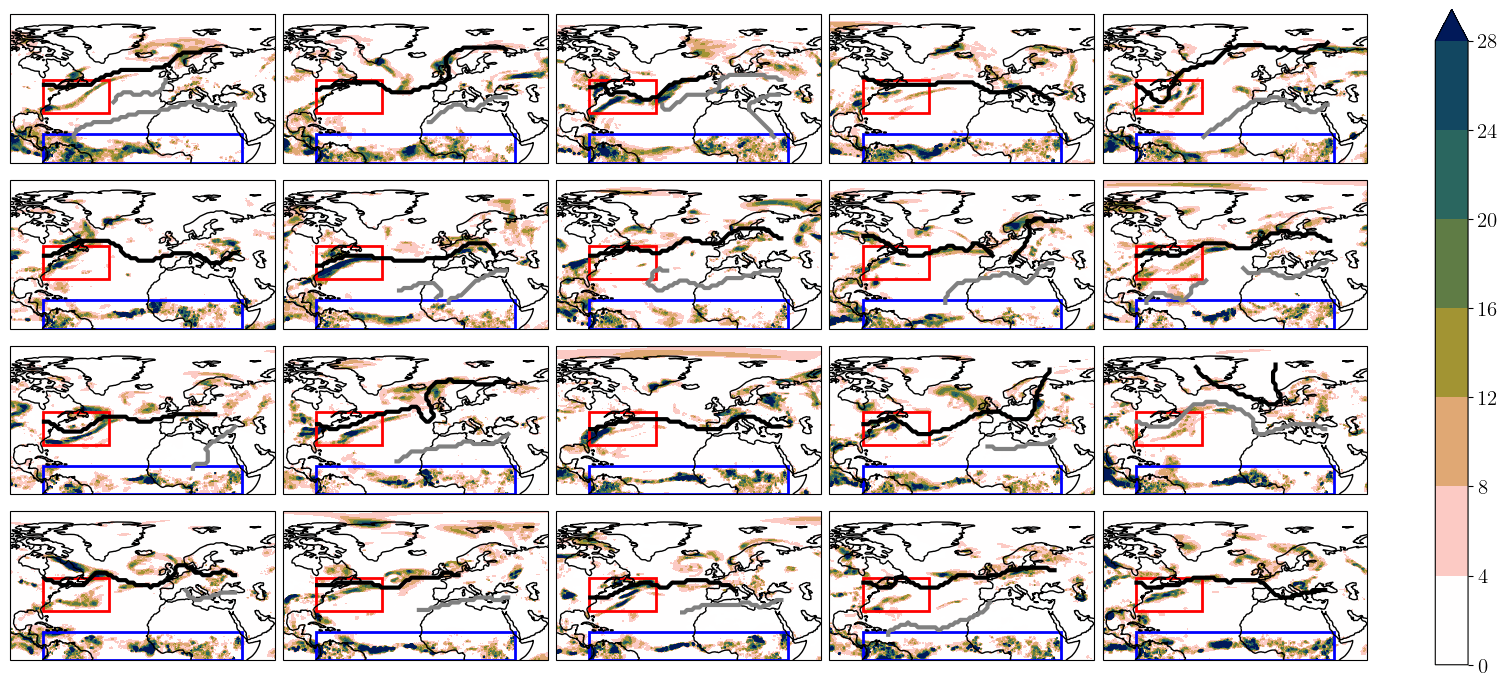

In [56]:
from matplotlib.patches import Rectangle
plt.rc("axes", titlesize=13)
da = da_tp.copy() * 1000
cmap = colormaps.batloww_r
plot_kwargs = {"cmap": cmap, "levels": MaxNLocator(7, symmetric=False).tick_values(0, da.quantile(0.99)).tolist()}

nrow, ncol = 3, 2
n = nrow * ncol
key = "EDJ_catd"
spells_from_jet = spells_list[key].filter(pl.col("relative_index") == 0)
clu = Clusterplot(4, 5, get_region(da))
to_plot = da.sel(time=spells_from_jet["time"].dt.round("1d"))
clu.add_contourf(to_plot, **plot_kwargs)
for i, t in enumerate(spells_from_jet["time"].dt.round("1d")):
    for _, jet in  phat_jets.group_by("jet ID"):
        lo, la, is_p = jet.filter(pl.col("time") == t)[["lon", "lat", "is_polar"]]
        try:
            # clu.axes[i].scatter(lo - clu.central_longitude, la, c=is_p, vmin=0, vmax=1, cmap=colormaps.cet_l_bmw_r, marker="x", s=10)
            color = "black" if len(is_p) > 0 and is_p.mean() > 0.5 else "grey"
            clu.axes[i].plot(lo - clu.central_longitude, la, color=color, lw=3)
        except IndexError:
            continue
    rect = Rectangle((-80 - clu.central_longitude, 30), 40, 20, linewidth=2, edgecolor='r', facecolor='none')
    clu.axes[i].add_patch(rect)
    rect = Rectangle((-80 - clu.central_longitude, 0), 120, 17, linewidth=2, edgecolor='b', facecolor='none')
    clu.axes[i].add_patch(rect)

#